In [2]:
import polaris as po
import math
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

competition_name: str = "antiviral-potency-2025"
# competition_name: str = "antiviral-admet-2025"

competition = po.load_competition(f"asap-discovery/{competition_name}")
data_dir: Path = Path(f"../data/{competition_name}")

# competition.cache(data_dir)


[2025-02-24 11:30:18] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=334804;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=641088;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=795943;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=471632;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [3]:
train, test = competition.get_train_test_split()

print("Targets:")
print(train.target_cols)
print("Dataset size:")
print(competition.size())
print("Train size:")
print(len(train))

print("Train size per target:")
# Filter nans out of train set
# this should/could be one line :(
num_of_values = dict()
for target in train.target_cols:
    values = 0
    for i in range(0, len(train)):
        if not math.isnan(train[i][1].get(target)):
            values += 1
    num_of_values[target] = values
print(num_of_values)

print("Test size:")
print(len(test))



Targets:
['pIC50 (SARS-CoV-2 Mpro)', 'pIC50 (MERS-CoV Mpro)']
Dataset size:
(1328, 4)
Train size:
1031
Train size per target:
{'pIC50 (SARS-CoV-2 Mpro)': 842, 'pIC50 (MERS-CoV Mpro)': 901}
Test size:
297


In [4]:
# the same, but better + min max avg
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    print(tgt)
    print("Number of samples "+ str(sum(mask)))

    print("min - avg - max")
    min = np.min(y[mask])
    avg = np.average(y[mask])
    max = np.max(y[mask])
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))


    print("--------------------")

pIC50 (SARS-CoV-2 Mpro)
Number of samples 842
min - avg - max
4.0 5.32 8.68
--------------------
pIC50 (MERS-CoV Mpro)
Number of samples 901
min - avg - max
1.0 4.77 9.0
--------------------


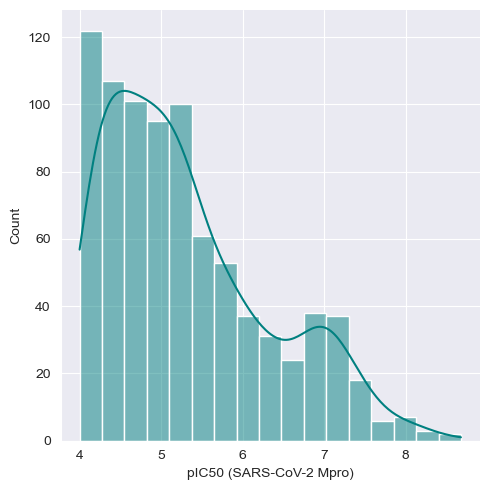

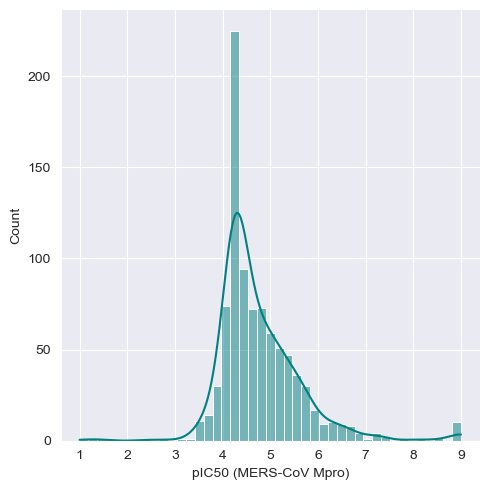

In [4]:
# draw distribution for each target
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    data = train.y[tgt][mask]
    sns.displot(data=pd.DataFrame({tgt: data}),
            x=tgt, kde=True, color='teal')
plt.show()

In [5]:
# get mols from smiles
smiles_train = [smiles[0] for smiles in train]
mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]


smiles_test = test
mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]

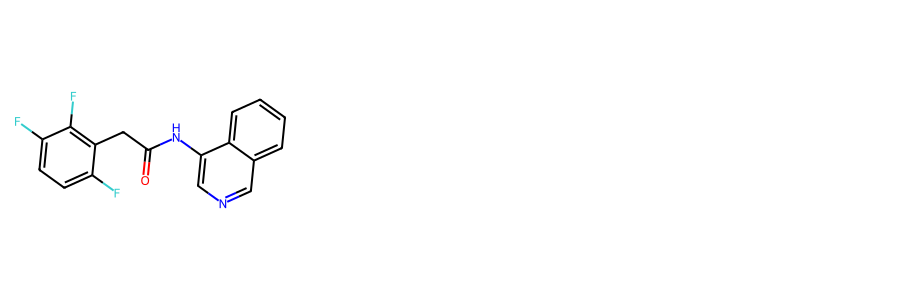

In [6]:
# draw some molecules for each target for each category (min, avg, max)
# Draw.MolsToGridImage(mols_test, molsPerRow=3, subImgSize=(300, 300))

#for tgt in train.target_cols: # why doesn't it print those, if I loop it :(
tgt = 'pIC50 (MERS-CoV Mpro)' #['pIC50 (MERS-CoV Mpro)', 'pIC50 (SARS-CoV-2 Mpro)']
y = train.y[tgt]
mask = ~np.isnan(y)
min = np.min(y[mask])

min_indices = np.where(y == min)[0]
mols = [mols_train[i] for i in min_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

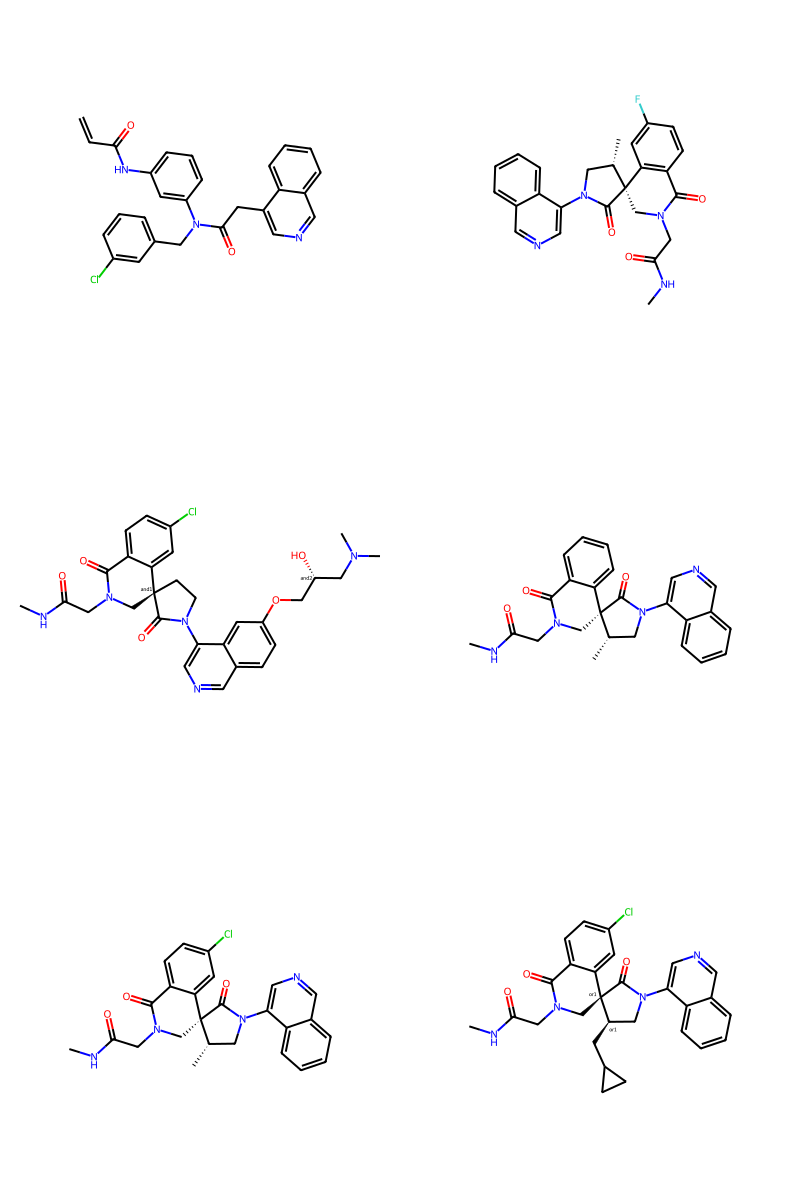

In [12]:
max = np.max(y[mask])

max_indices = np.where(y == max)[0]
mols = [mols_test[i] for i in range(6)]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400))

In [ ]:
avg = np.average(y[mask])

avg_indices = [0] # todo: find avg indices
mols = [mols_train[i] for i in avg_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
# distribution of molecular weight
# train

weights = [ExactMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [ExactMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of molecular weight
# train

weights = [HeavyAtomMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [HeavyAtomMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of number of atoms
# train

weights = [mol.GetNumAtoms() for mol in mols_train]
sns.displot(data=pd.DataFrame({"Num Atoms Train": weights}),
            x="Num Atoms Train", kde=True, color='teal')
plt.show()

#test

weights = [mol.GetNumAtoms() for mol in mols_test]
sns.displot(data=pd.DataFrame({"Num Atoms Test": weights}),
            x="Num Atoms Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of similarity in train/test
# train
fps_train = [FingerprintMols.FingerprintMol(x) for x in mols_train]
sim = []

for i in range(len(fps_train)-1):
    for j in range(i, len(fps_train)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_train[j]))

sns.displot(data=pd.DataFrame({"Similarity in Train": sim}),
            x="Similarity in Train", kde=True, color='teal')
plt.show()

#test
fps_test = [FingerprintMols.FingerprintMol(x) for x in mols_test]
sim = []

for i in range(len(fps_test)-1):
    for j in range(i, len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_test[i], fps_test[j]))


sns.displot(data=pd.DataFrame({"Similarity in Test": sim}),
            x="Similarity in Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of similarity between train and test
sim = []
for i in range(len(fps_train)):
    for j in range(len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_test[j]))

sns.displot(data=pd.DataFrame({"Similarity between Train and Test": sim}),
            x="Similarity between Train and Test", kde=True, color='teal')



In [ ]:
# distribution of max similarity between train and test
sim = []
for i in range(len(fps_test)):
    max = 0
    for j in range(len(fps_train)):
        simi = DataStructs.TanimotoSimilarity(fps_test[i], fps_train[j])
        if simi > max:
            max = simi
    sim.append(max)

sns.displot(data=pd.DataFrame({"Max Similarity between Test and Train": sim}),
            x="Max Similarity between Test and Train", kde=True, color='teal')


In [ ]:
# scatter tgt vs mol weight
for tgt in train.target_cols:
    weights = [HeavyAtomMolWt(mol) for mol in mols_train]
    sns.scatterplot(data=pd.DataFrame({"Weights Train": weights, tgt:train.y[tgt]}),
            x="Weights Train",y=tgt, color='teal')
    plt.show()


In [ ]:
print(train[0][1])
print(train[1][1])
print(train[2][1])

In [ ]:
# mol sizes

# train
smiles = [smiles[0] for smiles in train]

mols = [Chem.MolFromSmiles(smiles[i]) for i in range(len(smiles))]
mol_sizes = [mol.GetNumAtoms() for mol in mols]
# mol weight

# test
smiles_test = [smiles[0] for smiles in train]

mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]
mol_sizes_test = [mol.GetNumAtoms() for mol in mols_test]


# use atom weight
# print(mol_sizes_test)

## Create Potency CSV Datasets

In [26]:
train_data = {
    "smiles": [],
    "pIC50 (MERS-CoV Mpro)": [],
    "pIC50 (SARS-CoV-2 Mpro)": []
}

test_data = {
    "smiles": list(test),
}

for entry in train:
    train_data["smiles"].append(entry[0])
    train_data["pIC50 (MERS-CoV Mpro)"].append(entry[1]["pIC50 (MERS-CoV Mpro)"])
    train_data["pIC50 (SARS-CoV-2 Mpro)"].append(entry[1]["pIC50 (SARS-CoV-2 Mpro)"])

In [30]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("../data/polaris/potency/train_polaris.csv", index=False)
test_df.to_csv("../data/polaris/potency/test_polaris.csv", index=False)